All the import statements in one cell.

In [1]:
import json
import pickle
import gc
import glob
import re
import tarfile
from datetime import datetime, timezone
from collections import Counter
from subprocess import Popen, PIPE

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import dask.bag as db
import dask.distributed

from hist import Hist

In [2]:
client = dask.distributed.Client(n_workers=8, threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 8,Total memory: 62.10 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34457,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 62.10 GiB
Comm: tcp://127.0.0.1:33489,Total threads: 1
Dashboard: http://127.0.0.1:45011/status,Memory: 7.76 GiB
Nanny: tcp://127.0.0.1:45465,


Only need to do this if `/tmp/*` is out of date, not every time the notebook gets relaunched.

In [ ]:
cmssw_file_ages = list(json.load(open("/home/jpivarski/storage/data/physicists/forks-of-cmssw-2023-02-13/file-ages.json")).items())

In [ ]:
len(cmssw_file_ages)

In [ ]:
start = stop = 0
for i in range(100):
    stop = min(stop + int(np.ceil(len(cmssw_file_ages) / 100)), len(cmssw_file_ages))
    pickle.dump(dict(cmssw_file_ages[start:stop]), open(f"/tmp/cmssw-file-ages-{i}.pkl", "wb"))
    start = stop

In [ ]:
root_file_ages = list(json.load(open("/home/jpivarski/storage/data/physicists/github-archive/file-ages.json")).items())

In [ ]:
len(root_file_ages)

In [ ]:
start = stop = 0
for i in range(100):
    stop = min(stop + int(np.ceil(len(root_file_ages) / 100)), len(root_file_ages))
    pickle.dump(dict(root_file_ages[start:stop]), open(f"/tmp/root-file-ages-{i}.pkl", "wb"))
    start = stop

Start here if relaunching the notebook.

In [3]:
cmssw_file_ages_names = db.from_sequence([f"/tmp/cmssw-file-ages-{i}.pkl" for i in range(100)])
root_file_ages_names = db.from_sequence([f"/tmp/root-file-ages-{i}.pkl" for i in range(100)])

In [4]:
cmssw_repo_fraction_commits = {}
for filename in glob.glob("/home/jpivarski/storage/data/physicists/forks-of-cmssw-2023-02-13/user-repos-contributors/*.json"):
    reponame = filename[90:-5].replace("__", "/")
    if reponame == "Abdoelabassi/Quantum/qiskit/Starter":
        reponame = "Abdoelabassi/Quantum__qiskit__Starter"
    assert reponame.count("/") == 1, reponame
    owner = reponame[:reponame.index("/")]
    filedata = open(filename).read()
    if len(filedata.strip()) == 0:
        cmssw_repo_fraction_commits[reponame] = 0.0
    else:
        contributors = json.loads(filedata)
        if isinstance(contributors, dict) and contributors["message"] in ("Moved Permanently", "Not Found", "Repository access blocked"):
            cmssw_repo_fraction_commits[reponame] = 0.0
        else:
            total_commits = sum(x["contributions"] for x in contributors)
            if total_commits == 0:
                cmssw_repo_fraction_commits[reponame] = 1.0
            else:
                cmssw_repo_fraction_commits[reponame] = sum(x["contributions"] for x in contributors if x["login"] == owner) / total_commits

In [5]:
root_repo_fraction_commits = {}
for filename in glob.glob("/home/jpivarski/storage/data/physicists/github-archive/root-repo-user-repos-contributors/*.json"):
    reponame = filename[89:-5].replace("__", "/")
    assert reponame.count("/") == 1, reponame
    owner = reponame[:reponame.index("/")]
    contributors = json.load(open(filename))
    if isinstance(contributors, dict) and contributors["message"] in ("The history or contributor list is too large to list contributors for this repository via the API.", "Not Found", "Repository access blocked"):
        root_repo_fraction_commits[reponame] = 0.0
    else:
        total_commits = sum(x["contributions"] for x in contributors)
        if total_commits == 0:
            root_repo_fraction_commits[reponame] = 1.0
        else:
            root_repo_fraction_commits[reponame] = sum(x["contributions"] for x in contributors if x["login"] == owner) / total_commits

In [6]:
cmssw_repo_exclude = {name for name, fraction in cmssw_repo_fraction_commits.items() if fraction < 0.01}
root_repo_exclude = {name for name, fraction in root_repo_fraction_commits.items() if fraction < 0.01}

In [7]:
len(cmssw_repo_exclude), len(root_repo_exclude)

(577, 186)

In [8]:
# These take a long time to compute and they aren't physics related.
cmssw_repo_exclude.add("hrishikeshgoyal/NetBSD-kernel-source")

root_repo_exclude.add("GuacheSuede/MSCVProject")
root_repo_exclude.add("GuacheSuede/MSSubmission1234567890")

In [9]:
cmssw_repo_dir = "/home/jpivarski/storage/data/GitHub-CMSSW-user-nonfork-raw-data-1Mcut"
root_repo_dir = "/home/jpivarski/storage/data/GitHub-ROOT-user-nonfork-raw-data-1Mcut"

In [10]:
def cpp_file_extension(filename):
    x = filename.lower()
    return x.endswith(".c") or x.endswith(".cc") or x.endswith(".cpp") or x.endswith(".cp") or x.endswith(".cxx") or x.endswith(".c++") or x.endswith(".h") or x.endswith(".hpp") or x.endswith(".hp") or x.endswith(".hh")

In [11]:
cmssw_bios = json.load(open("/home/jpivarski/storage/data/physicists/forks-of-cmssw-2023-02-13/cmssw-bios.json"))
root_bios = json.load(open("/home/jpivarski/storage/data/physicists/github-archive/root-repo-bios.json"))

In [12]:
def select(x):
    if x is None or x.strip() == "":
        return False
    else:
        return re.search("(phys|analy|hep|particle|cern|cms|atlas|alice|lhc)", x, re.I) is not None

(
    100 * len([x for x in cmssw_bios if select(x["bio"])]) / len(cmssw_bios),
    100 * len([x for x in root_bios if select(x["bio"])]) / len(root_bios),
)

(7.690217391304348, 7.613314447592068)

In [13]:
cmssw_physicists = set(x["name"] for x in cmssw_bios if select(x["bio"]))
root_physicists = set(x["name"] for x in root_bios if select(x["bio"]))

len(cmssw_physicists), len(root_physicists)

(283, 215)

## Question 5

How many Python files can be parsed as Python 2 versus Python 3?

In [14]:
def parsable_python(text, version):
    return Popen(
        [f"/home/jpivarski/mambaforge/envs/{version}/bin/python", "-iuc", "import ast, sys; sys.ps1, sys.ps2 = '', ''"],
        stdin=PIPE, stdout=PIPE, stderr=PIPE,
    ).communicate(
        f"try:\n    tmp = ast.parse({text!r})\nexcept SyntaxError:\n    print('BAD')\nelse:\n    print('GOOD')\n".encode()
    )[0] == b"GOOD\n"

In [15]:
parsable_python("print 'hi'", "py27")

True

In [16]:
parsable_python("print 'hi'", "py311")

False

In [17]:
def calculate_python2_python3(filename):
    # gc.disable()
    batch = pickle.load(open(filename, "rb"))
    if filename.startswith("/tmp/cmssw-file-ages"):
        repo_exclude = cmssw_repo_exclude
        physicists = cmssw_physicists
        repo_dir = cmssw_repo_dir
    else:
        repo_exclude = root_repo_exclude
        physicists = root_physicists
        repo_dir = root_repo_dir
    
    out = []
    for reponame, repo in batch.items():
        username = reponame.split("/")[0]
        
        if reponame not in repo_exclude and username in physicists:
            with tarfile.open(f"{repo_dir}/{reponame}.tgz") as repo_tgz:
                for info in repo_tgz:
                    if info.isfile():
                        filetype = "other"
                        text = None
                        py2parsable, py3parsable = False, False

                        if info.name.lower().endswith(".ipynb"):
                            filedata = repo_tgz.extractfile(info).read()
                            try:
                                jsondata = json.loads(filedata)
                            except (json.JSONDecodeError, UnicodeDecodeError):
                                filetype = "broken-Jupyter"
                            else:
                                filetype = "Jupyter"
                                text = "\n\n\n".join(["".join(cell["source"]) for cell in jsondata.get("cells", []) if cell["cell_type"] == "code"])
                                text = text.encode("utf-8")

                        elif info.name.lower().endswith(".py"):
                            filetype = "Python"
                            text = repo_tgz.extractfile(info).read()
                        
                        if text is not None:
                            py2parsable = parsable_python(text, "py27")
                            py3parsable = parsable_python(text, "py311")
                        
                        try:
                            file_date = datetime.strptime(repo["/".join(info.name.split("/")[2:])][0], "%Y-%m-%d %H:%M:%S %z")
                        except (ValueError, KeyError):
                            file_date = datetime(1970, 1, 1, tzinfo=timezone.utc)
                        
                        out.append({"type": filetype, "py2": py2parsable, "py3": py3parsable, "date": file_date})
        
    return out

In [18]:
batches1 = cmssw_file_ages_names.map(calculate_python2_python3).compute()

In [19]:
batches2 = root_file_ages_names.map(calculate_python2_python3).compute()

In [20]:
df = pd.DataFrame(
    {
        "type": [x["type"] for batch in batches1 + batches2 for x in batch],
        "py2": [x["py2"] for batch in batches1 + batches2 for x in batch],
        "py3": [x["py3"] for batch in batches1 + batches2 for x in batch],
    },
    index=[x["date"] for batch in batches1 + batches2 for x in batch],
)
df

,type,py2,py3
2021-05-06 18:31:11+00:00,other,False,False
2020-12-03 17:14:49+00:00,other,False,False
2020-06-23 16:40:04+00:00,other,False,False
2020-06-23 16:43:14+00:00,other,False,False
2020-06-22 17:04:10+00:00,other,False,False
...,...,...,...
2016-11-10 20:49:44+00:00,other,False,False
2016-11-10 20:49:44+00:00,other,False,False
2016-11-10 20:49:44+00:00,other,False,False
2016-11-22 01:33:38+00:00,other,False,False


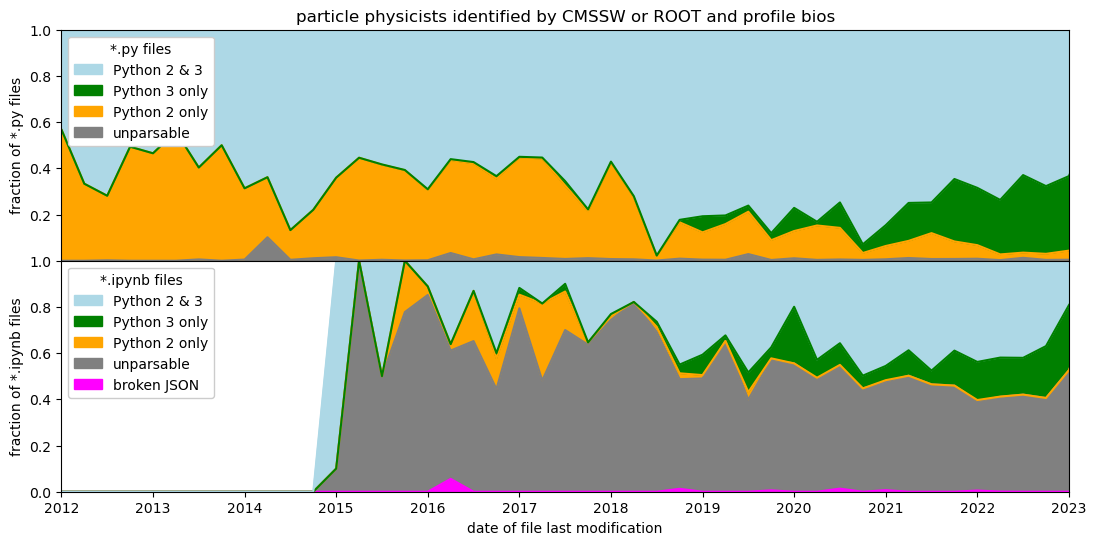

In [75]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 6))

c = plt.rcParams["axes.prop_cycle"].by_key()["color"]

df["unparsable"] = (df["type"] == "Python") & ~df["py2"] & ~df["py3"]
df["Python 2 only"] = (df["type"] == "Python") & df["py2"] & ~df["py3"]
df["Python 3 only"] = (df["type"] == "Python") & ~df["py2"] & df["py3"]
df["Python 2 & 3"] = (df["type"] == "Python") & df["py2"] & df["py3"]
df["Total"] = df["type"] == "Python"

df2 = df[[
    "unparsable",
    "Python 2 only",
    "Python 3 only",
    "Python 2 & 3",
    "Total"
]].resample("Q", origin=pd.to_datetime("2013-01-01")).sum()

df2.div(df2["Total"], axis=0)[[
    "unparsable",
    "Python 2 only",
    "Python 3 only",
    "Python 2 & 3",
]].plot.area(ax=ax1, stacked=True, color=["gray", "orange", "green", "lightblue"]);

df["broken JSON"] = df["type"] == "broken-Jupyter"
df["unparsable"] = (df["type"] == "Jupyter") & ~df["py2"] & ~df["py3"]
df["Python 2 only"] = (df["type"] == "Jupyter") & df["py2"] & ~df["py3"]
df["Python 3 only"] = (df["type"] == "Jupyter") & ~df["py2"] & df["py3"]
df["Python 2 & 3"] = (df["type"] == "Jupyter") & df["py2"] & df["py3"]
df["Total"] = (df["type"] == "broken-Jupyter") | (df["type"] == "Jupyter")

df2 = df[[
    "broken JSON",
    "unparsable",
    "Python 2 only",
    "Python 3 only",
    "Python 2 & 3",
    "Total"
]].resample("Q", origin=pd.to_datetime("2013-01-01")).sum()

df2.div(df2["Total"], axis=0)[[
    "broken JSON",
    "unparsable",
    "Python 2 only",
    "Python 3 only",
    "Python 2 & 3",
]].plot.area(ax=ax2, stacked=True, color=["magenta", "gray", "orange", "green", "lightblue"]);

ax1.set_title("particle physicists identified by CMSSW or ROOT and profile bios");
ax1.set_ylim(0, 1);
ax1.set_xlim(pd.to_datetime("2012-03-01"), pd.to_datetime("2023-03-01"));
ax1.set_xticks([]);
ax1.set_ylabel("fraction of *.py files");
ax1.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0]);

handles, labels = ax1.get_legend_handles_labels();
ax1.legend(handles[::-1], labels[::-1], title="*.py files", loc="upper left", facecolor="white", framealpha=1);

ax2.set_ylim(0, 1);
ax2.set_xlim(pd.to_datetime("2012-03-01"), pd.to_datetime("2023-03-01"));
ax2.set_xticks([pd.to_datetime(f"{x}-01-01") for x in range(2012, 2023+1)], [str(x) for x in range(2012, 2023+1)]);
ax2.set_ylabel("fraction of *.ipynb files");
ax2.set_xlabel("date of file last modification");
ax2.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0]);

handles, labels = ax2.get_legend_handles_labels();
ax2.legend(handles[::-1], labels[::-1], title="*.ipynb files", loc="upper left", facecolor="white", framealpha=1);

plt.subplots_adjust(hspace=0);

fig.savefig("github-python-2-3-fraction.svg");
fig.savefig("github-python-2-3-fraction.pdf");

## Question 6

Which repos (without the bio cut) import Uproot or Awkward, so that I can ask specific questions about those repos?

In [98]:
def calculate_uproot_awkward_search(filename):
    # gc.disable()
    batch = pickle.load(open(filename, "rb"))
    if filename.startswith("/tmp/cmssw-file-ages"):
        repo_exclude = cmssw_repo_exclude
        repo_dir = cmssw_repo_dir
    else:
        repo_exclude = root_repo_exclude
        repo_dir = root_repo_dir

    out = []
    for reponame, repo in batch.items():
        username = reponame.split("/")[0]

        if reponame not in repo_exclude:
            out_repo = {"name": reponame, "files": []}
            good_repo = False

            with tarfile.open(f"{repo_dir}/{reponame}.tgz") as repo_tgz:
                for info in repo_tgz:
                    if info.isfile():
                        out_file = {"name": info.name, "type": None, "text": None, "date": 0}
                        good_file = False

                        if info.name.lower().endswith(".ipynb"):
                            filedata = repo_tgz.extractfile(info).read()
                            try:
                                jsondata = json.loads(filedata)
                            except (json.JSONDecodeError, UnicodeDecodeError):
                                pass
                            else:
                                out_file["type"] = "ipynb"
                                out_file["text"] = "\n\n\n".join(["".join(cell["source"]) for cell in jsondata.get("cells", []) if cell["cell_type"] == "code"])

                        elif info.name.lower().endswith(".py"):
                            out_file["type"] = "py"
                            out_file["text"] = repo_tgz.extractfile(info).read().decode("utf-8", errors="surrogateescape")

                        if out_file["text"] is not None:
                            if re.search(r"^\s*(import\s+(uproot[34]?|awkward[01]?)\b|from\s+(uproot[34]?|awkward[01]?)\s+import)", out_file["text"], re.M) is not None:
                                good_repo = True
                                good_file = True

                        try:
                            out_file["date"] = datetime.strptime(repo["/".join(info.name.split("/")[2:])][0], "%Y-%m-%d %H:%M:%S %z").timestamp()
                        except (ValueError, KeyError):
                            pass

                        if good_file:
                            out_repo["files"].append(out_file)

            if good_repo:
                out.append(out_repo)

    return out

In [99]:
all_file_ages_names = db.from_sequence([f"/tmp/cmssw-file-ages-{i}.pkl" for i in range(100)] + [f"/tmp/root-file-ages-{i}.pkl" for i in range(100)])

In [100]:
batches = all_file_ages_names.map(calculate_uproot_awkward_search).compute()

In [102]:
json.dump(sum(batches, []), open("/home/jpivarski/storage/data/GitHub-all-user-nonfork-uproot-awkward.json", "w"))